In [70]:
import pandas as pd
import numpy as np
from nltk.stem.porter import PorterStemmer  
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize 
import math
from sklearn.decomposition import LatentDirichletAllocation
from stop_words import get_stop_words
from sklearn.cluster import MiniBatchKMeans , KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk import sent_tokenize, word_tokenize, PorterStemmer
from nltk.corpus import stopwords
import re 
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier , LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score , confusion_matrix , accuracy_score, matthews_corrcoef , silhouette_score
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from sklearn.metrics import f1_score
from sklearn.calibration import CalibratedClassifierCV
from yellowbrick.cluster import KElbowVisualizer
import sys
import warnings
from sklearn import svm
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [71]:
cat =  pd.read_csv('Categorie.20210726.csv')
strings = pd.read_csv('Stringhe.20210726.csv')

In [72]:
strings = strings.reset_index(drop = True)

In [73]:
strings[strings['DescrizioneStringa'].str.contains('cinture')]

,ID,DescrizioneStringa,IDTipoInformazione,Sigla,IDCategoria
268,269,Spia delle cinture di sicurezza,1,"BOD, STR",NaN
269,270,Spia delle cinture di sicurezza,2,STR,NaN
669,670,Spia mancato allacciamento cinture,1,BOD,NaN
670,671,Spia mancato allacciamento cinture,1,"BOD, STR",NaN
944,945,Avviso cinture sicurezza,1,STR,62.0
1356,1357,Spia cinture di sicurezza,1,STR,NaN
1735,1736,Spia cinture di sicurezza,1,STR,NaN
1736,1737,Spia cinture di sicurezza,1,STR,NaN


In [74]:
haedlines = strings['DescrizioneStringa']
lemma = WordNetLemmatizer()
ps = PorterStemmer()
corpus = []
corpus1 = []
for i in range(len(haedlines)):
    #rev = re.sub(r'[^\w]', ' ',headlines[i])
    rev = re.sub('[^a-zA-Z]',' ',haedlines[i])
    rev = rev.lower()
    rev = rev.split()
    rev_stem = [ps.stem(word) for word in rev]
    rev_lemma = [lemma.lemmatize(word1) for word1 in rev]
    rev_stem = ' '.join(rev_stem)
    rev_lemma = ' '.join(rev_lemma)
    corpus.append(rev_stem)
    corpus1.append(rev_lemma)

In [75]:
strings = pd.concat([strings,pd.Series(corpus,name = 'Stemming'),pd.Series(corpus,name = 'Lemmatize')],axis = 1)

### TfidfVectorizer for stemmed.

In [76]:
italian_stopwords = get_stop_words('italian')
tfidf = TfidfVectorizer(
    max_features = 8000,
    stop_words = italian_stopwords)
tfidf.fit(corpus)
text = tfidf.transform(corpus)
X = text

### TfidfVectorizer for lemmatized.

In [77]:
tfidf.fit(corpus1)
text1 = tfidf.transform(corpus1)
X1 = text1

### Model for stemmed words

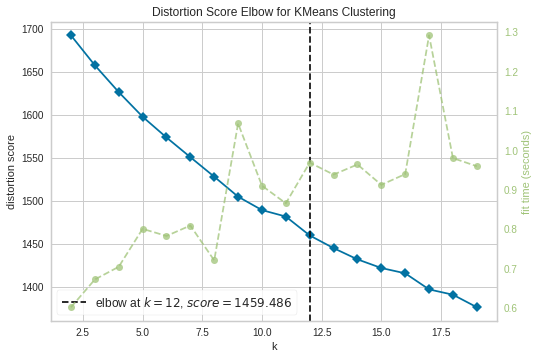

In [78]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,20), timings= True)
visualizer.fit(text)
visualizer.show()

In [86]:
model_tfidf = KMeans(n_clusters = 12)
model_tfidf.fit(text)
strings['TfIdfClusters'] = model_tfidf.labels_
pd.Series(model_tfidf.labels_).value_counts()

0     591
7     296
2     179
1     129
4     100
9      89
5      87
8      83
3      75
10     59
11     56
6      37
dtype: int64

In [87]:
categorizedstring = strings[~strings['IDCategoria'].isna()]
catlist = pd.DataFrame (data = categorizedstring.groupby('IDCategoria')['TfIdfClusters'].apply(list))
catlist['UniqueCluster'] = catlist['TfIdfClusters'].apply(lambda x: np.unique(x))
catlist.head(10)

,TfIdfClusters,UniqueCluster
IDCategoria,,
0.0,[2],[2]
1.0,"[0, 6, 0]","[0, 6]"
2.0,"[10, 10]",[10]
3.0,"[0, 0, 0]",[0]
4.0,"[6, 0]","[0, 6]"
5.0,"[1, 0]","[0, 1]"
6.0,"[0, 0, 0, 0]",[0]
7.0,"[0, 0, 4, 4]","[0, 4]"
8.0,"[0, 0, 0]",[0]


In [88]:
clusterlist = pd.DataFrame (data = categorizedstring.groupby('TfIdfClusters')['IDCategoria'].apply(list))
clusterlist.head(50)

,IDCategoria
TfIdfClusters,
0,"[23.0, 33.0, 14.0, 32.0, 19.0, 16.0, 1.0, 114...."
1,"[13.0, 28.0, 21.0, 72.0, 28.0, 72.0, 70.0, 21...."
2,"[14.0, 20.0, 23.0, 20.0, 76.0, 54.0, 76.0, 25...."
3,"[81.0, 85.0, 82.0, 86.0, 83.0, 87.0, 84.0, 88...."
4,"[12.0, 12.0, 12.0, 7.0, 7.0, 12.0, 10.0]"
5,"[32.0, 61.0, 59.0, 56.0, 57.0, 59.0, 59.0]"
6,"[1.0, 23.0, 4.0, 29.0, 64.0]"
7,"[75.0, 11.0, 10.0, 11.0, 18.0, 19.0, 75.0, 11...."
8,"[56.0, 56.0, 61.0, 57.0]"


### Model for lemmatized words. 

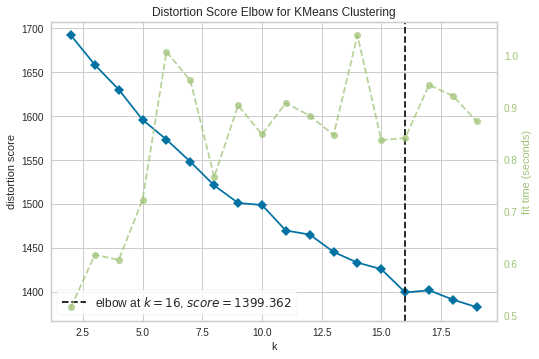

In [89]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,20), timings= True)
visualizer.fit(text1)
visualizer.show()

In [90]:
model_tfidf = KMeans(n_clusters = 16)
model_tfidf.fit(text)
strings['TfIdfClusters1'] = model_tfidf.labels_
pd.Series(model_tfidf.labels_).value_counts()

1     565
3     246
11    154
9     108
5      97
2      95
0      88
10     67
4      67
8      59
14     56
6      43
12     40
7      37
15     35
13     24
dtype: int64

In [91]:
categorizedstring = strings[~strings['IDCategoria'].isna()]
catlist = pd.DataFrame (data = categorizedstring.groupby('IDCategoria')['TfIdfClusters1'].apply(list))
catlist['UniqueCluster'] = catlist['TfIdfClusters1'].apply(lambda x: np.unique(x))
catlist.head(10)

,TfIdfClusters1,UniqueCluster
IDCategoria,,
0.0,[5],[5]
1.0,"[1, 15, 1]","[1, 15]"
2.0,"[9, 9]",[9]
3.0,"[1, 1, 1]",[1]
4.0,"[15, 1]","[1, 15]"
5.0,"[11, 1]","[1, 11]"
6.0,"[1, 13, 1, 1]","[1, 13]"
7.0,"[6, 6, 10, 10]","[6, 10]"
8.0,"[1, 1, 1]",[1]


In [92]:
clusterlist = pd.DataFrame (data = categorizedstring.groupby('TfIdfClusters1')['IDCategoria'].apply(list))
clusterlist.head(50)

,IDCategoria
TfIdfClusters1,
0,"[56.0, 56.0, 61.0, 57.0]"
1,"[23.0, 33.0, 14.0, 20.0, 23.0, 32.0, 19.0, 16...."
2,"[20.0, 76.0, 76.0, 15.0, 12.0, 12.0, 12.0, 73...."
3,"[73.0, 11.0, 11.0, 18.0, 19.0, 11.0, 9.0, 9.0,..."
4,"[32.0, 61.0, 59.0, 56.0, 57.0, 59.0, 59.0]"
5,"[14.0, 54.0, 25.0, 26.0, 65.0, 54.0, 14.0, 65...."
6,"[75.0, 7.0, 7.0, 75.0]"
7,"[45.0, 81.0, 82.0, 83.0, 84.0, 42.0, 15.0, 67...."
8,"[81.0, 85.0, 82.0, 86.0, 83.0, 87.0, 84.0, 88...."
